## Problem Set 8

### Problem 0

Run the cell below to make sure you are in the data1030 coding environment. 

We will deduct 2 points for every missing OK sign. (If you don't run the cell, that's -14 points.)


In [47]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.11.4"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.11"):
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.24.4", 'matplotlib': "3.7.2",'sklearn': "1.3.0", 
                'pandas': "2.0.3",'xgboost': "1.7.6", 'shap': "0.42.1", 'seaborn': "0.12.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.11.5

[ OK ] numpy version 1.24.4 is installed.
[ OK ] matplotlib version 3.7.2 is installed.
[ OK ] sklearn version 1.3.0 is installed.
[ OK ] pandas version 2.0.3 is installed.
[ OK ] xgboost version 1.7.6 is installed.
[ OK ] shap version 0.42.1 is installed.
[ OK ] seaborn version 0.12.2 is installed.


## Introduction - ML Ethics 

In this problem set we'll explore algorithmic bias using a dataset containing information on criminal offenders screened in Florida from 2013 to 2014. The target variable (`two_year_recid`) for this dataset indicates whether or not an individual committed another crime after being released from prision. 

Machine learning models, known as Risk Assessment Tools (RATs), have been developed based on this and other similar datasets. The goal of these tools is to predict the likelihood of an individual commiting a future crime. These predictive scores are increasingly being used to inform decisions throughout the criminal justice system, including assigning bond amounts and determining sentencing lengths. As you can imagine, false positives and false negatives have severe consequences for the defendant and society in general.

On top of this, the introduction of large language models (LLMs) has added new technical and moral considersations to the development of these predictive pipelines. Increasingly, LLMs are being integrated into the workflows of data scientists who are tasked with creating RATs and other socially centered tools. As such, we will also explore the benefits and limitations of using LLMs to develop socially critical machine learning pipelines.

This problem set is broken down into the following sections:

1. Use ChatGPT to perform EDA on the dataset and answer questions related to ChatGPT's effectiveness  
2. Use ChatGPT to develop a machine learning pipeline, and discuss your findings
3. Debug your inital pipeline and study the model's algorithmic bias

Throughout this problem set you should only be using GPT-3.5. This will allow us to standardize the process across submissions. The csv file and a description are available in the `data` folder.

You can read more about the topic [here](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) and [here](https://arxiv.org/pdf/2106.05498.pdf).

## Problem 1

In this section we'll perform EDA to get a better sense of our dataset and target variable. You should prompt ChatGPT to create graphics and feature descriptions that would be helpful for better understanding the data. Copy and paste the link to your ChatGPT conversation by clicking on the share icon in the top right hand corner on the ChatGPT UI. We list out several items that you should include in your EDA responses, but feel free to do as much EDA as you'd like! 

Note that you may need to drop some columns that clearly have no predictive power (i.e. id and name). 

### Problem 1a (5 points)

Load in the dataset and perform EDA to show the following:

1. The target variable (using .describe or .value_counts)
3. The datatypes for each feature
4. The fraction of missing values for each feature 
5. The unique races and genders in the dataset and how many people belong to each racial and gender group 

In [48]:
# your code here 
import pandas as pd
import numpy as np 

df = pd.read_csv("data/recidivism_data.csv")
# The target variable (using .describe or .value_counts)
print(df['two_year_recid'].describe())


count    7214.000000
mean        0.450652
std         0.497593
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: two_year_recid, dtype: float64


In [49]:
# The datatypes for each feature
print(df.dtypes.to_string())

id                      int64
name                   object
sex                    object
age                     int64
age_cat                object
race                   object
juv_fel_count           int64
juv_misd_count          int64
juv_other_count         int64
priors_count            int64
c_charge_degree        object
r_days_from_arrest    float64
two_year_recid          int64
c_jail_days           float64
custody_days          float64


In [50]:
# The fraction of missing values for each feature 
print(df.isnull().mean())

id                    0.000000
name                  0.000000
sex                   0.000000
age                   0.000000
age_cat               0.000000
race                  0.000000
juv_fel_count         0.000000
juv_misd_count        0.000000
juv_other_count       0.000000
priors_count          0.000000
c_charge_degree       0.000000
r_days_from_arrest    0.678958
two_year_recid        0.000000
c_jail_days           0.042556
custody_days          0.032714
dtype: float64


In [51]:
# The unique races and genders in the dataset and how many people belong to each racial and gender group
print(df['race'].value_counts())
print(df['sex'].value_counts())

race
African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: count, dtype: int64
sex
Male      5819
Female    1395
Name: count, dtype: int64


### Problem 1b (10 points)

Now let's have ChatGPT perform further EDA to develop the following plots. Keep in mind that we will use accuracy as the evaluation metric:

1. Visualize the target variable 
    - Is the dataset balanced? 
    - What's the baseline accuracy? 
2. Prepare 3 figures to visualize correlations between various features and the target variable 
    - As usual, choose an appropriate visualization type, include axis labels and titles, and write a caption explaining what the figures show. 
    - One figure should show the target variable vs. gender and race.

After completing the above EDA, answer the following questions:

1. In your opinion, how good is ChatGPT at exploring datasets?
2. Could ChatGPT correctly determine whether variables are continuous/ordinal/categorical?
3. Could ChatGPT select appropriate figure types? Were the axes labeled and units shown?
4. Did you encounter buggy code that you had to fix?

Remember to share the link to your ChatGPT session!


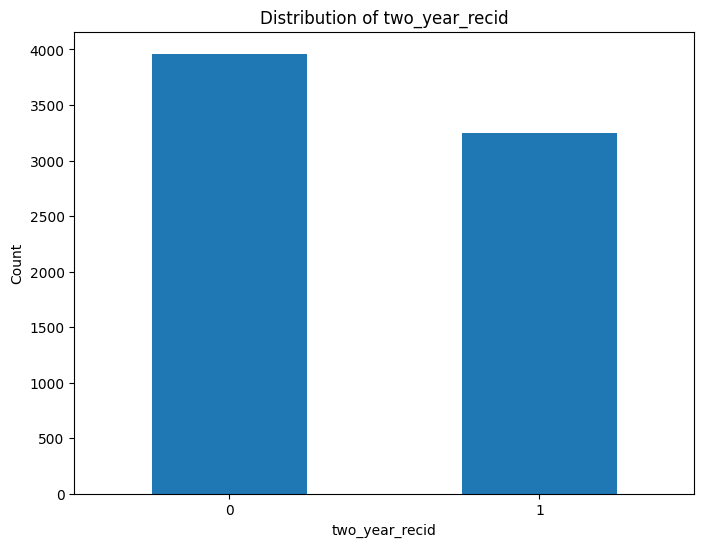

Baseline Accuracy: 0.5493484890490713


In [52]:
# Visualize the target variable 

import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset (assuming it's stored in a DataFrame called 'df')
# Replace 'df' with the actual name of your DataFrame if different.

# Create a bar plot for the target variable
plt.figure(figsize=(8, 6))
df['two_year_recid'].value_counts().plot(kind='bar')
plt.title('Distribution of two_year_recid')
plt.xlabel('two_year_recid')
plt.ylabel('Count')
plt.xticks(rotation=0)  # To keep the x-axis labels horizontal
plt.show()

# Calculate baseline accuracy
baseline_accuracy = df['two_year_recid'].value_counts(normalize=True)[0]
print("Baseline Accuracy:", baseline_accuracy)


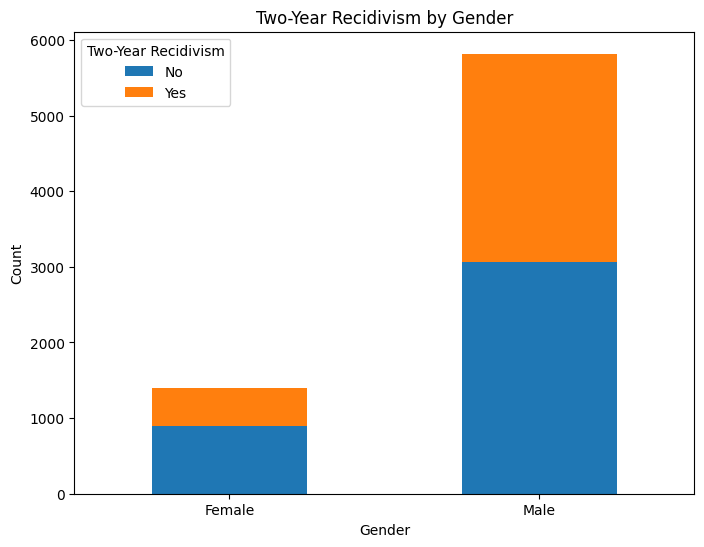

In [53]:
# Prepare 3 figures to visualize correlations between various features and the target variable 

import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset (assuming it's stored in a DataFrame called 'df')
# Replace 'df' with the actual name of your DataFrame if different.

# Create a bar plot to visualize the relationship between gender and two_year_recid
gender_vs_recid = df.groupby(['sex', 'two_year_recid']).size().unstack()
gender_vs_recid.plot(kind='bar', stacked=True, figsize=(8, 6))

plt.title('Two-Year Recidivism by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Two-Year Recidivism', labels=['No', 'Yes'])
plt.show()

# Caption: This figure shows the distribution of two-year recidivism (No/Yes) across different genders. It helps us understand how gender is related to recidivism.


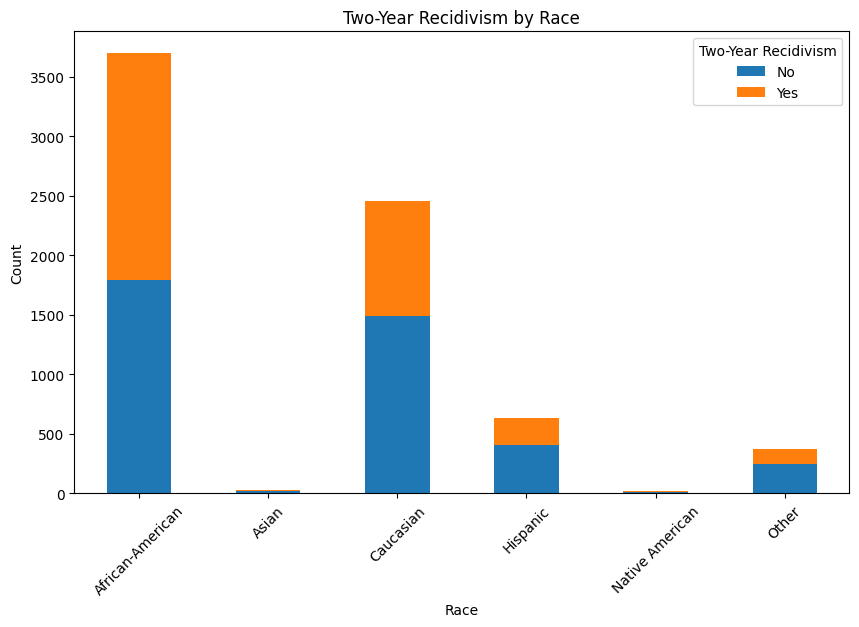

In [54]:
# Create a bar plot to visualize the relationship between race and two_year_recid
race_vs_recid = df.groupby(['race', 'two_year_recid']).size().unstack()
race_vs_recid.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Two-Year Recidivism by Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Two-Year Recidivism', labels=['No', 'Yes'])
plt.show()

# Caption: This figure illustrates the distribution of two-year recidivism (No/Yes) across different racial categories. It provides insights into the relationship between race and recidivism.

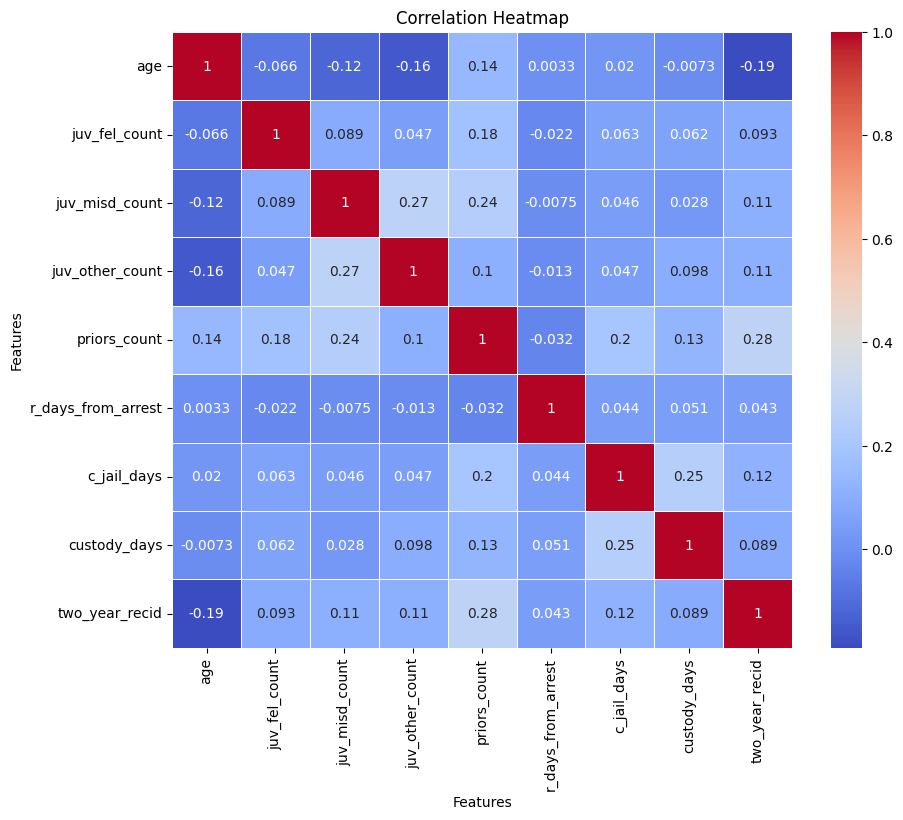

In [55]:
import seaborn as sns

# Create a correlation heatmap to visualize the correlations between numeric features and two_year_recid
numeric_features = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'r_days_from_arrest', 'c_jail_days', 'custody_days']
correlation_matrix = df[numeric_features + ['two_year_recid']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

# Caption: This heatmap displays the correlations between numeric features and the target variable (two_year_recid). Positive or negative values indicate the strength and direction of the relationships.

Personally speaking, ChatGPT excels in Exploratory Data Analysis (EDA). Once I provide the column names of my dataset, it adeptly recognizes each variable as continuous, ordinal, or categorical. Impressively, it selects suitable plots for visualizing each feature. ChatGPT anticipates my needs by highlighting the three most significant features for exploration, even without specific guidance from me. Though they lack units, the plots it generates are straightforward and well-annotated with labels, legends, and titles. I've seamlessly executed ChatGPT's code without encountering bugs, just copy-paste directly to here. 

The link to the chat: https://chat.openai.com/share/a90a79c5-2bb1-40cd-afb6-e7aed2552068

## Problem 2

In this section, you will build an entire machine learning pipeline to predict the target variable using an XGBoost classifier. You will first use ChatGPT to generate the machine learning pipeline. Then, you'll examine ChatGPT's output and answer ethical questions regarding the use of LLMs for these types of tasks. Next, you'll debug the pipeline so that it can be used to generate predicts, which we can study for algorithmic bias. Remember you should only be using GPT-3.5 to answer these questions!

### Problem 2a (6 points)

Write a prompt that asks ChatGPT to generate a pipeline to perform the following:

1. load in the data 
2. split the data (this dataset is IID)
3. preprocesse the data 
4. train an XGBoost model 
    - tune at least one hyper parameter and use early stopping
    - train on five different random states 
5. save train and test scores 

Copy in the prompt you used to generate the pipeline, as well as the code itself. You can also paste in the link to your ChatGPT conversation by clicking on the share icon in the top right hand corner. 

Answer the following questions:
- What are the shortcomings of ChatGPT's work? Does the code run? If so, are the outputs as expected?
- Besides buggy code, what is one technical issue with relying on ChatGPT to generate a pipeline?
- What is one societal issue with relying on ChatGPT to generate a pipeline?
- Given the issues you identified above, what role should LLMs play in the data science work stream?

**your prompt here**

give me a data science pipeline in Python perform following things:
1. load in the data 
2. split the data (this dataset is IID)
3. preprocesse the data 
4. train an XGBoost model 
    - tune at least one hyper parameter and use early stopping
    - train on five different random states 
5. save train and test scores 

here are the description of the dataset:
id                      int64
name                   object
sex                    object
age                     int64
age_cat                object
race                   object
juv_fel_count           int64
juv_misd_count          int64
juv_other_count         int64
priors_count            int64
c_charge_degree        object
r_days_from_arrest    float64
two_year_recid          int64
c_jail_days           float64
custody_days          float64

the target variable is 'two_year_recid' 

In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import joblib

# Step 1: Load the data
data = pd.read_csv("data/recidivism_data.csv")  # Replace 'your_dataset.csv' with the actual file path

# Step 2: Split the data
X = data.drop(columns=['two_year_recid'])  # Features
y = data['two_year_recid']  # Target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Preprocess the data
# Encode categorical variables (e.g., 'sex', 'age_cat', 'race', 'c_charge_degree')
label_encoders = {}
categorical_cols = ['sex', 'age_cat', 'race', 'c_charge_degree']
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Train an XGBoost model with hyperparameter tuning and early stopping
best_models = []
for random_state in range(5):
    # Split the training data into training and validation sets (90% train, 10% validation)
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=random_state)

    # Define the XGBoost classifier
    xgb_classifier = XGBClassifier(objective='binary:logistic', random_state=random_state)

    # Hyperparameter tuning with GridSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1, 0.01, 0.001],
        'min_child_weight': [1, 3, 5]
    }
    
    grid_search = GridSearchCV(xgb_classifier, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train_split, y_train_split)

    best_xgb_model = grid_search.best_estimator_

    # Fit the best model on the full training data with early stopping
    best_xgb_model.fit(X_train_split, y_train_split, early_stopping_rounds=10, eval_set=[(X_val, y_val)], verbose=False)

    best_models.append(best_xgb_model)

# Step 5: Save train and test scores
train_scores = []
test_scores = []

for model in best_models:
    # Train score
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_scores.append(train_accuracy)

    # Test score
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_scores.append(test_accuracy)

# Save train and test scores to a file or print them
print("Train Scores:", train_scores)
print("Test Scores:", test_scores)

# You can also save the best models using joblib
for i, model in enumerate(best_models):
    joblib.dump(model, f'xgb_model_{i}.pkl')


ValueError: could not convert string to float: 'joshua flewellyn'

session link: https://chat.openai.com/share/bf262b06-4f31-4a14-b7c0-fb14b8e42a10

**your answers here**

A limitation in ChatGPT's output is that it requires manual input of the dataset path after generating code, as it doesn't automatically detect this. Additionally, the code often encounters issues, such as a 'ValueError: could not convert string to float: 'joshua flewellyn'', indicating that ChatGPT sometimes selects inappropriate encoders for certain columns or features.

One societal issue with relying heavily on ChatGPT or similar large language models (LLMs) to generate a data science pipeline is the risk of perpetuating biases present in the training data. LLMs, like ChatGPT, learn from vast amounts of data sourced from the internet, which can include biased or incorrect information. This means that if the underlying data contains biases or inaccuracies, the model may unknowingly replicate these biases in its outputs. For example, in data analysis, this could lead to skewed interpretations or misleading conclusions, especially if the biases are not identified and corrected.

Given this issue, the role of LLMs in the data science workflow should ideally be that of an assistant or a tool, rather than a sole decision-maker. They can be immensely helpful in automating repetitive tasks, generating initial code frameworks, or providing suggestions for data analysis techniques. However, human oversight is crucial. Data scientists should critically evaluate and validate the model's suggestions, especially when it comes to interpreting results and making decisions based on the data. By combining the efficiency and capabilities of LLMs with human expertise and ethical consideration, the potential risks of bias can be mitigated, leading to more accurate and trustworthy outcomes in data science projects.

### Problem 2b (10 points)

Now let's debug ChatGPT's code to develop a working pipeline! You can either debug the code manually, or you can continue to prompt ChatGPT to fix previous mistakes. If you choose to further prompt ChatGPT, please include your full conversation by pasting in your session link as explained above. 

In addition to getting the pipeline up and running, please do the following:

1. Save the test scores and 5 best models in lists 
2. Save each random state's test set into a list 
    - You should save both the feature matrix and the target series. We will use these sets later to evaluate our model for bias 
    - The sets should be converted into dataframes before being added to the list 
3. Plot the correlation coefficient matrix for the last random state using the training set 
    - Should any of the features be dropped? 
4. Print the mean and standard deviation of the test scores 

The pipeline we built for this assignment has an average test accuracy of 0.842 with a standard deviation of 0.012 across five random states. Your numbers may vary due to randomness but you should look for scores around these benchmarks.

Fitting 3 folds for each of 18 candidates, totalling 54 fits


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Fitting 3 folds for each of 18 candidates, totalling 54 fits


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Fitting 3 folds for each of 18 candidates, totalling 54 fits


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Fitting 3 folds for each of 18 candidates, totalling 54 fits


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Fitting 3 folds for each of 18 candidates, totalling 54 fits


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


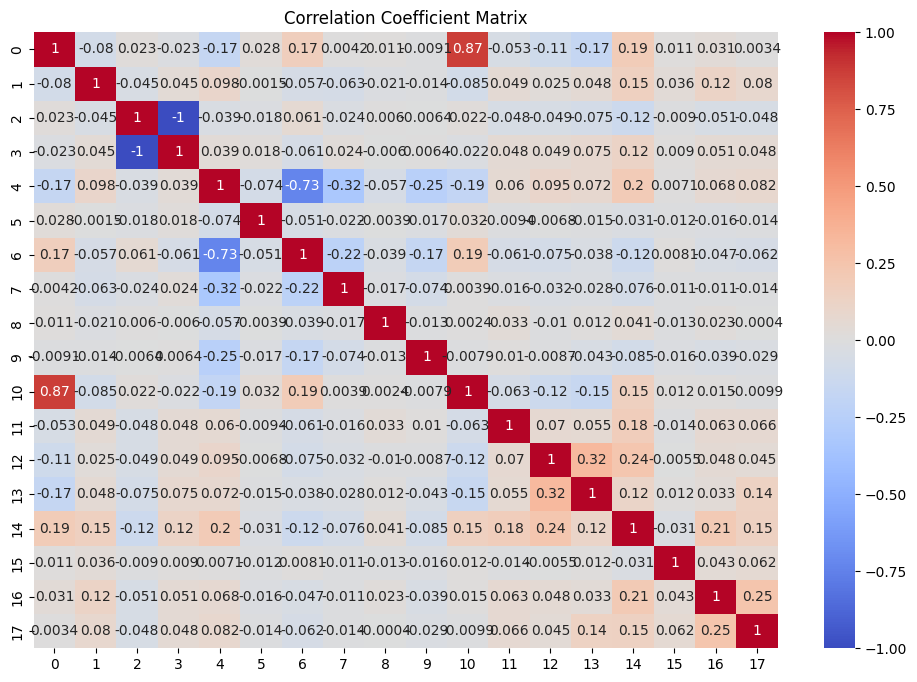

Mean Test Score: 0.8461182994454713
Standard Deviation of Test Scores: 0.006476099091073905


In [66]:
# your code here 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Step 1: Load the data
data = pd.read_csv("data/recidivism_data.csv")
 

# Step 2: Split the data
data.drop(columns=['name', 'id'], inplace=True)
X = data.drop(columns=['two_year_recid'])  # Features
y = data['two_year_recid']  # Target variable


# Step 3: Preprocess the data
# Encode categorical variables (e.g., 'sex', 'age_cat', 'race', 'c_charge_degree')
ordinal_ftrs = ['age_cat', 'c_charge_degree'] 
ordinal_cats = [['Less than 25','25 - 45','Greater than 45'],
                ['M', 'F']]
onehot_ftrs = ['sex','race']
minmax_ftrs = ['age']
std_ftrs = ['juv_fel_count','juv_misd_count', 'juv_other_count', 'priors_count', 'r_days_from_arrest', 'c_jail_days', 'custody_days']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)]) 


# Step 4: Train an XGBoost model with hyperparameter tuning and early stopping
test_sets = [] # Save each random state's test set into a list 

best_models = [] # Save the test scores and 5 best models in lists 
for random_state in range(5):
    # Split the training data into training and validation sets 
    X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.6, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_train, y_train, test_size=0.5, random_state=random_state)
    
    X_train = clf.fit_transform(X_train)
    X_val =clf.fit_transform(X_val)
    X_test = clf.transform(X_test)
    
    # Save each random state's test set into a list 
    y_test_reset = y_test.reset_index(drop=True)
    test_set_df = pd.DataFrame(X_test)
    test_set_df['18'] = y_test_reset
    test_sets.append(test_set_df)

    # Define the XGBoost classifier
    xgb_classifier = XGBClassifier(objective='binary:logistic', random_state=random_state)

    # Hyperparameter tuning with GridSearchCV
    param_grid = {
        'n_estimators': [10000],
        'max_depth': [1, 2, 3, 5, 10, 50],
        'learning_rate': [0.1, 0.01, 0.001],
        'subsample': [0.66],
        'colsample_bytree': [0.9] 
    }
    
    grid_search = GridSearchCV(xgb_classifier, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_xgb_model = grid_search.best_estimator_

    # Fit the best model on the full training data with early stopping
    best_xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_val, y_val)], verbose=False)

    best_models.append(best_xgb_model)
    
    if random_state == 4: # Plot the correlation coefficient matrix for the last random state using the training set 
        correlation_matrix = pd.DataFrame(X_train).corr()
        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
        plt.title("Correlation Coefficient Matrix")
        plt.show()

# Step 5: Save train and test scores
train_scores = []
test_scores = [] # Save the test scores and 5 best models in lists 

for model in best_models:
    # Train score
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_scores.append(train_accuracy)

    # Test score
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_scores.append(test_accuracy)

# Step 6: Print Mean and Standard Deviation of Test Scores
mean_test_score = np.mean(test_scores)
std_test_score = np.std(test_scores)
print(f"Mean Test Score: {mean_test_score}")
print(f"Standard Deviation of Test Scores: {std_test_score}")

Upon checking the correlation coefficient matrix, it is observed that certain feature pairs exhibit high correlation. Feature 10 and feature 0 is highly positively correlated. Feature 3 and feature 2 is highly negatively correlated. It is advisable to consider the potential multicollinearity implications of these correlations on the predictive model. When two features have a correlation coefficient that exceeds the absolute value of 0.8, they may convey redundant information, which could be problematic for certain types of models.

However, given the use of an XGBoost algorithm, which tends to be robust against multicollinearity, the necessity to drop correlated features is less stringent. It remains critical to factor in domain-specific knowledge to ascertain the importance of each feature. If domain expertise indicates that both elements of a highly correlated pair are crucial, then retaining both may be justified. Otherwise, to streamline the model and possibly enhance performance, one feature from each highly correlated pair could be removed.

## Problem 3

In this final section, we will use the 5 best models to create predictions for each data point in the saved test sets. We will aggregate these predictions together into one dataframe that we can investigate for a more holistic overview of our models' performance. We will also study the bias that the model has for and against certain genders and races. 


### Problem 3a (10 points)

In this problem, you will work with the 5 models and test sets that you saved in Problem 2. Specifically, use each of the models to predict the target labels of the data points in their corresponding test sets. You should concatenate these predictions, the true labels, and the original test sets into one master dataframe. For guidance, your final dataframe should have the shape: (`num_test_datapoints * 5, num_features + 2`). The two additional columns in this dataframe should be for the true and predicted values of each data point.

Print out the overall accuracy of the model!

In [69]:
df_new =pd.DataFrame()

for i in range(5):
    curr_pred = best_models[i].predict(test_sets[i].iloc[:, :-1])
    print(test_sets[i].shape)
    curr_pred_df = pd.DataFrame(curr_pred)
    tmp = pd.concat([test_sets[i], curr_pred_df], axis=1)
    print(tmp.shape)
    df_new = pd.concat([df_new, tmp], ignore_index=True)

print(df_new.shape)

(2164, 19)
(2164, 20)
(2164, 19)
(2164, 20)
(2164, 19)
(2164, 20)
(2164, 19)
(2164, 20)
(2164, 19)
(2164, 20)
(10820, 20)


In [71]:
print(f'the overall accuracy score is: {accuracy_score(df_new.iloc[:, -2], df_new.iloc[:, -1])}')

the overall accuracy score is: 0.8498151571164511


### Problem 3b (6 points)

We will now disaggregate the results and study the model's performance across various racial and gender groups. Let's focus on Caucasians and African-Americans because not many people belong to the other racial groups. 

Calculate and plot the following. The confusion matrices should be normalized with respect to the true conditions. We've provided the expected output for the female-only confusion matrix for your reference:

1. overall accuracy and confusion matrix for males
2. overall accuracy and confusion matrix for females
3. overall accuracy and confusion matrix for Caucasians
4. overall accuracy and confusion matrix for African-Americans

Study the accuracies and the normalized false positives in the confusion matrices!

Write a couple of paragraphs and discuss your findings. How do you feel about the overall accuracy of the model? Are there racial and gender groups for which the model performs better/worse? What do the false positives in the confusion matrix mean for criminal defendants?

![alt text](images/confusion_mat.png)


In [77]:
# your code here
transformed_feature_names = preprocessor.get_feature_names_out()
df_new.columns = list(transformed_feature_names) + ["true_labels", "predictions"]
print(df_new.columns)
print(len(df_new.columns))

Index(['ord__age_cat', 'ord__c_charge_degree', 'onehot__sex_Female',
       'onehot__sex_Male', 'onehot__race_African-American',
       'onehot__race_Asian', 'onehot__race_Caucasian', 'onehot__race_Hispanic',
       'onehot__race_Native American', 'onehot__race_Other', 'minmax__age',
       'std__juv_fel_count', 'std__juv_misd_count', 'std__juv_other_count',
       'std__priors_count', 'std__r_days_from_arrest', 'std__c_jail_days',
       'std__custody_days', 'true_labels', 'predictions'],
      dtype='object')
20


Accuracy for Males: 0.8431012730817754


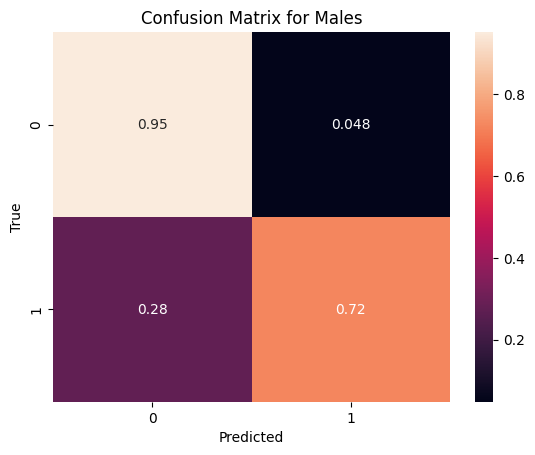

Accuracy for Females: 0.8776772965254641


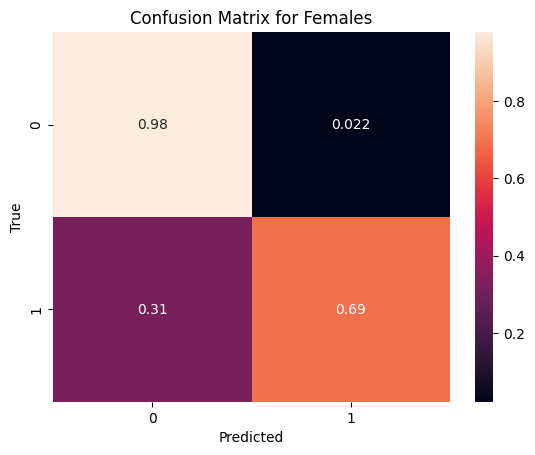

Accuracy for Caucasians: 0.8686786296900489


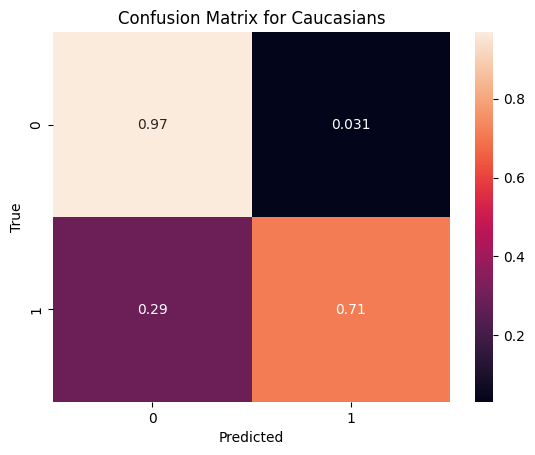

Accuracy for African-Americans: 0.833181900781392


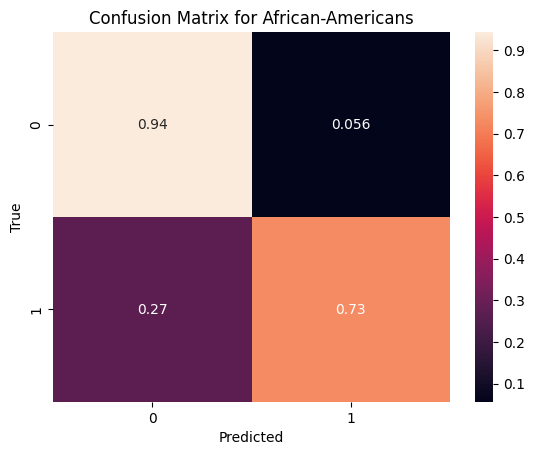

In [82]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define groups based on one-hot encoded columns
groups = {
    'Males': df_new['onehot__sex_Male'] == 1,
    'Females': df_new['onehot__sex_Female'] == 1,
    'Caucasians': df_new['onehot__race_Caucasian'] == 1,
    'African-Americans': df_new['onehot__race_African-American'] == 1
}

# Calculate and plot accuracy and confusion matrices for each group
for group_name, group_condition in groups.items():
    group_data = df_new[group_condition]
    accuracy = accuracy_score(group_data['true_labels'], group_data['predictions'])
    conf_matrix = confusion_matrix(group_data['true_labels'], group_data['predictions'], normalize='true')

    print(f"Accuracy for {group_name}: {accuracy}")
    sns.heatmap(conf_matrix, annot=True)
    plt.title(f"Confusion Matrix for {group_name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

The analysis reveals notable differences in the model's performance across gender and racial groups. The model is more accurate for females (87.8%) compared to males (84.3%), and for Caucasians (86.9%) versus African-Americans (83.3%).  Although the accuracy seems high, given the context of the problem, having around 15% of the people misclassified isn't great. This discrepancy raises concerns about potential biases, particularly given the higher false positive rates for males (4.8%) and African-Americans (5.6%), compared to females (2.2%) and Caucasians (3.1%). These false positives are critical in a criminal justice context, as they represent individuals incorrectly predicted to reoffend. This could lead to unfairly harsher treatment for certain groups, especially African-Americans. While the model shows reasonable overall accuracy, its varying performance across different demographics underscores a need for caution. Ensuring fairness and avoiding bias in such models is crucial, given their significant implications in legal settings.